# GDP Nowcasting - Data Collection

The objective of this notebook is to collect data for Peruvian GDP nowcasting, based in the top 10 Peruvian GDP predictors identified by <a href='#FPerez'>F. Pérez (2018).</a>

## Outline

- <a href='#BCRP'> BCRP DATA </a>
	- <a href='#dif'> Data in differences </a>
    - <a href='#lev'> Data in levels </a>
    - <a href='#all_bcrp'> Merge of BCRP Data </a>
- <a href='#fred'> FRED DATA </a>
- <a href='#BCRP + FRED DAT'> Merge of BCRP and FRED data </a>
- <a href='#ref'> References </a>

In [1]:
import datetime
import requests


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas_datareader as pdr


from math import sqrt
from statsmodels.tsa.filters.hp_filter import hpfilter

## <a id='BCRP'> BCRP DATA </a>

### <a id='dif'> Data in differences </a>

In [2]:
## Basic parameters
url_base="https://estadisticas.bcrp.gob.pe/estadisticas/series/api/"
formato="/json"
per="/2004-1/2023-02"

## List of variables
series_list = ["PN01728AM", # Producto bruto interno y demanda interna (variaciones porcentuales anualizadas) - PBI
               "PD37965AM", # Indicadores de coyuntura - Electricidad (var% 12 meses)
               "PD37967GM", # Indicadores de coyuntura - Consumo interno de cemento (var% 12 meses)
               "PD37975BM", # Indicadores de coyuntura - Volumen de importación de insumos industriales (var% 12 meses)
               "PN00498MM" # Crédito de las sociedades creadoras de depósito al sector privado - fin de periodo (var% 12 meses) - Crédito MN
              ]

## Empty dictionaries
url = {}
ans = {}
dfs = {}

## Loop to get variables from BCRP Request
for i in range(len(series_list)):
    url[series_list[i]] = url_base+series_list[i]+formato+per
    ans[series_list[i]] = requests.get(url[series_list[i]])
    dfs[series_list[i]] = pd.DataFrame(ans[series_list[i]].json()["periods"])
    dfs[series_list[i]]["values"] = dfs[series_list[i]]["values"].str[0].astype(float)
    
dates = dfs[series_list[i]]["name"]

df_dif = pd.concat([dates,
                dfs["PN01728AM"]["values"],
                dfs["PD37965AM"]["values"],
                dfs["PD37967GM"]["values"],
                dfs["PD37975BM"]["values"],
                dfs["PN00498MM"]["values"]],
               axis=1,
               keys=['dates', 'gdp', 'p_elec', 'c_cement', 'm_ind_inp', 'cred_mn'])

date = pd.date_range('1/1/2004', periods = df_dif.shape[0], freq ='m')
df_dif['date'] = pd.to_datetime(date, errors='coerce')
df_dif.set_index('date', inplace=True)
df_dif

,dates,gdp,p_elec,c_cement,m_ind_inp,cred_mn
date,,,,,,
2004-01-31,Ene.2004,3.674966,4.229032,6.868890,-16.532481,13.514563
2004-02-29,Feb.2004,4.245959,7.350977,6.468289,9.215095,9.453369
2004-03-31,Mar.2004,5.774257,5.436382,7.780494,-2.812554,8.226966
2004-04-30,Abr.2004,4.247995,6.194900,2.201965,7.594470,5.003304
2004-05-31,May.2004,3.950757,6.124446,2.770659,19.005229,4.772573
...,...,...,...,...,...,...
2022-08-31,Ago.2022,1.980758,3.120912,1.280000,20.024885,5.273741
2022-09-30,Sep.2022,2.090679,4.888810,-2.362744,7.500270,4.152657
2022-10-31,Oct.2022,2.321467,4.944038,-6.409437,5.490030,3.669293


### <a id='lev'> Data in levels </a>

In [3]:
## Basic parameters
url_base="https://estadisticas.bcrp.gob.pe/estadisticas/series/api/"
formato="/json"
per="/2003-1/2023-02"

## List of variables
series_list = ["PN38070GM", # Empleo en Lima Metropolitana - Promedio móvil tres meses (miles de personas) - Ingreso Mensual
               "PN01142MM", # Bolsa de Valores de Lima - Índices Bursátiles - Índice General BVL (base 31/12/91 = 100) 
              ]

## Empty dictionaries
url = {}
ans = {}
dfs = {}

## Loop to get variables from BCRP Request
for i in range(len(series_list)):
    url[series_list[i]] = url_base+series_list[i]+formato+per
    ans[series_list[i]] = requests.get(url[series_list[i]])
    dfs[series_list[i]] = pd.DataFrame(ans[series_list[i]].json()["periods"])
    dfs[series_list[i]]["values"] = dfs[series_list[i]]["values"].str[0].astype(float)
    
dates = dfs[series_list[i]]["name"]

df_level = pd.concat([dates,
                dfs["PN38070GM"]["values"],
                dfs["PN01142MM"]["values"]],
               axis=1,
               keys=['dates', 'empleo', 'bvl'])

date = pd.date_range('1/1/2003', periods = df_level.shape[0], freq ='m')
df_level['date'] = pd.to_datetime(date)
df_level.set_index('date', inplace=True)
df_level['delta_empleo'] = df_level['empleo'].pct_change(12,fill_method=None)*100
df_level['delta_bvl'] = df_level['bvl'].pct_change(12,fill_method=None)*100
df_level = df_level.iloc[12:][['dates', 'delta_empleo', 'delta_bvl']]
df_level

,dates,delta_empleo,delta_bvl
date,,,
2004-01-31,Ene.2004,0.598601,79.913009
2004-02-29,Feb.2004,2.283559,76.578574
2004-03-31,Mar.2004,2.043150,94.734749
2004-04-30,Abr.2004,2.619078,59.889402
2004-05-31,May.2004,1.549395,61.851754
...,...,...,...
2022-09-30,Sep.2022,8.499622,6.394772
2022-10-31,Oct.2022,10.622415,1.723618
2022-11-30,Nov.2022,11.817667,9.985585


### <a id='all_bcrp'> Merge of BCRP Data </a>

In [4]:
BCRP = pd.merge(df_dif,df_level, how='outer', left_index=True, right_index=True)
BCRP = BCRP.drop(columns=['dates_x', 'dates_y'])
BCRP

,gdp,p_elec,c_cement,m_ind_inp,cred_mn,delta_empleo,delta_bvl
date,,,,,,,
2004-01-31,3.674966,4.229032,6.868890,-16.532481,13.514563,0.598601,79.913009
2004-02-29,4.245959,7.350977,6.468289,9.215095,9.453369,2.283559,76.578574
2004-03-31,5.774257,5.436382,7.780494,-2.812554,8.226966,2.043150,94.734749
2004-04-30,4.247995,6.194900,2.201965,7.594470,5.003304,2.619078,59.889402
2004-05-31,3.950757,6.124446,2.770659,19.005229,4.772573,1.549395,61.851754
...,...,...,...,...,...,...,...
2022-09-30,2.090679,4.888810,-2.362744,7.500270,4.152657,8.499622,6.394772
2022-10-31,2.321467,4.944038,-6.409437,5.490030,3.669293,10.622415,1.723618
2022-11-30,1.877236,6.513948,-2.100000,6.987623,3.204154,11.817667,9.985585


## <a id='fred'> FRED DATA </a>

In [5]:
# (YYYY, M, D)
start = datetime.datetime (2003, 1, 1)
end = datetime.datetime (2023, 2, 1)

FRED = pdr.DataReader('INDPRO', 'fred', start, end)
FRED['delta_indpro'] = FRED['INDPRO'].pct_change(12,fill_method=None)*100

FRED = FRED.iloc[12:][['delta_indpro']]
FRED['date'] = pd.to_datetime(FRED.index) + pd.offsets.MonthEnd()
FRED.set_index('date', inplace=True)
FRED

,delta_indpro
date,
2004-01-31,1.279270
2004-02-29,1.784901
2004-03-31,1.681143
2004-04-30,2.745899
2004-05-31,3.509352
...,...
2022-09-30,4.731306
2022-10-31,3.189122
2022-11-30,1.984680


## <a id='BCRP + FRED DAT'> Merge of BCRP and FRED data </a>

In [6]:
df = pd.merge(BCRP,FRED, how='inner', left_index=True, right_index=True)
df.to_csv(r'.\data\nowcast_gdp_data.csv')
df

,gdp,p_elec,c_cement,m_ind_inp,cred_mn,delta_empleo,delta_bvl,delta_indpro
date,,,,,,,,
2004-01-31,3.674966,4.229032,6.868890,-16.532481,13.514563,0.598601,79.913009,1.279270
2004-02-29,4.245959,7.350977,6.468289,9.215095,9.453369,2.283559,76.578574,1.784901
2004-03-31,5.774257,5.436382,7.780494,-2.812554,8.226966,2.043150,94.734749,1.681143
2004-04-30,4.247995,6.194900,2.201965,7.594470,5.003304,2.619078,59.889402,2.745899
2004-05-31,3.950757,6.124446,2.770659,19.005229,4.772573,1.549395,61.851754,3.509352
...,...,...,...,...,...,...,...,...
2022-09-30,2.090679,4.888810,-2.362744,7.500270,4.152657,8.499622,6.394772,4.731306
2022-10-31,2.321467,4.944038,-6.409437,5.490030,3.669293,10.622415,1.723618,3.189122
2022-11-30,1.877236,6.513948,-2.100000,6.987623,3.204154,11.817667,9.985585,1.984680


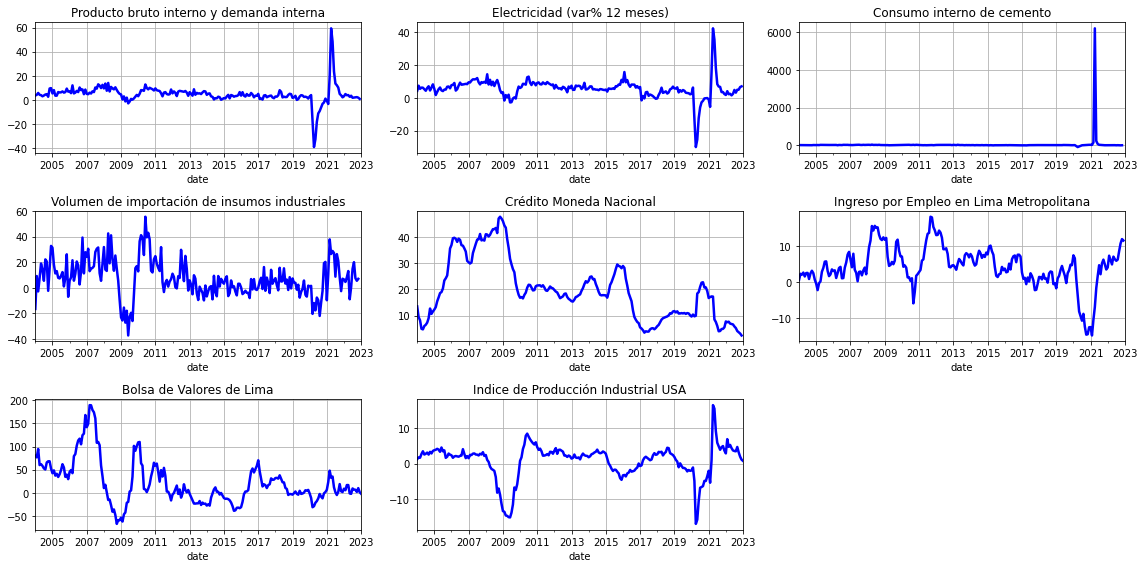

In [7]:
n_rows = round(sqrt(df.shape[1]))
n_cols = round(sqrt(df.shape[1]))
fig, axis = plt.subplots(nrows = n_rows,
                         ncols = n_cols,
                         figsize = (16,8))

var_names = ["Producto bruto interno y demanda interna",
             "Electricidad (var% 12 meses)",
             "Consumo interno de cemento",
             "Volumen de importación de insumos industriales",
             "Crédito Moneda Nacional",
             "Ingreso por Empleo en Lima Metropolitana",
             "Bolsa de Valores de Lima",
             "Indice de Producción Industrial USA"]

# Loop for subplot
idx = 1

for i in range(n_rows):
    for j in range (n_cols):
        
        # if idx is minor to number of elements
        if idx <= len(df.columns):
            ax = axis[i][j]
            df.plot(use_index=True,
                        y = df.columns[idx-1],
                        ax = ax,
                        color = 'blue',
                        linewidth=2.5,
                        legend = False)
            
            ax.set_title(var_names[idx-1])
            ax.grid(which='major')
            idx = idx + 1
            
        # if idx is major to number of elements        
        else:        
            axis[i,j].axis('off')
            idx = idx + 1
            
fig.tight_layout()

#plt.savefig(r".\images\gdp_nowcasting_variables.png", bbox_inches='tight')
#plt.savefig(r".\images\gdp_nowcasting_variables.eps", bbox_inches='tight')

# <a id='ref'> References </a>
<a id='FPerez'>Pérez, Fernando, 2018.</a> "Nowcasting Peruvian GDP using Leading Indicators and Bayesian Variable Selection," Working Papers 2018-010, Banco Central de Reserva del Perú. [PDF Link](https://www.bcrp.gob.pe/docs/Publicaciones/Documentos-de-Trabajo/2018/documento-de-trabajo-010-2018.pdf) 